In [1]:
!pip install rudalle==0.0.1rc2 > /dev/null

In [2]:
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle.image_prompts import ImagePrompts
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything

2021-11-02 19:14:37.459966: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


In [4]:
realesrgan = get_realesrgan('x4', device=device)
tokenizer = get_tokenizer()
vae = get_vae().to(device)
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
ruclip = ruclip.to(device)

x4 --> ready
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
ruclip --> ready


## image prompts by ruDALLE

In [5]:
import requests
from PIL import Image
import torch

red_sky_url = 'https://azur.ru/data/newfotos1/big/8/97908.jpg'
sunny_sky_url = 'https://99px.ru/sstorage/53/2016/04/mid_162114_1196.png'
cloudy_sky_url = 'https://vesti-lipetsk.ru/images/news/2020/01/18/bxcz2tot4t0.jpg'
night_sky_url = 'https://i.pinimg.com/originals/3c/51/82/3c5182ee0773333a3e0dd67d5ac41598.jpg'

red_sky = Image.open(requests.get(red_sky_url, stream=True).raw).resize((256, 256))
sunny_sky = Image.open(requests.get(sunny_sky_url, stream=True).raw).resize((256, 256))
cloudy_sky = Image.open(requests.get(cloudy_sky_url, stream=True).raw).resize((256, 256))
night_sky = Image.open(requests.get(night_sky_url, stream=True).raw).resize((256, 256))

skyes = [red_sky, sunny_sky, cloudy_sky, night_sky]

In [6]:
borders = {'up': 4, 'left': 0, 'right': 0, 'down': 0}
image_prompts = [
    ImagePrompts(sky, borders, vae, torch.device('cuda'), crop_first=True) for sky in skyes
]

In [7]:
text = 'Храм Василия Блаженного'
all_skyes_images = []

for image_prompt in image_prompts:
    seed_everything(42)
    pil_images = []
    for top_k, top_p, images_num in [
        (2048, 0.995, 3),
        (1536, 0.99, 3),
        (1024, 0.99, 3),
        (1024, 0.98, 3),
        (512, 0.97, 3),
        (384, 0.96, 3),
        (256, 0.95, 3),
        (128, 0.95, 3), 
    ]:
        _pil_images, _ = generate_images(
            text,
            tokenizer,
            dalle,
            vae,
            top_k=top_k,
            images_num=images_num,
            image_prompts=image_prompt,
            top_p=top_p,
            use_cache=False
        )
        pil_images += _pil_images
    top_images, _ = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device=device, count=5)
    all_skyes_images += super_resolution(top_images, realesrgan)

100%|██████████| 1024/1024 [01:11<00:00, 14.26it/s] 


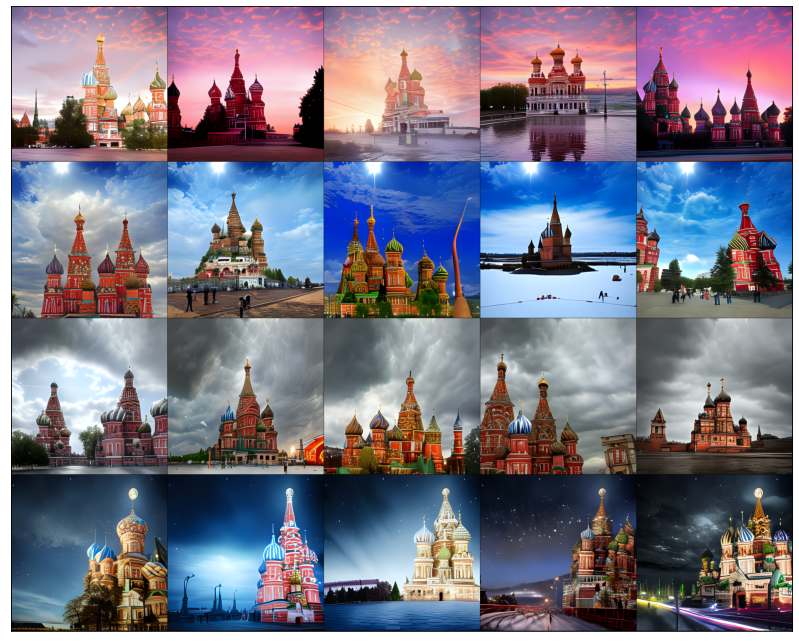

In [8]:
show(all_skyes_images, 5)